In [1]:
!pip install pycrf
!pip install sklearn-crfsuite


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install -U "scikit-learn<0.24"

  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [307 lines of output]
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation == "CPython"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX" and platform_python_implementation != "CPython"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
  Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
    Obtaining dependency information for setuptools from https://files.pythonhosted.org/


  Using cached scikit-learn-0.23.2.tar.gz (7.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


In [5]:
!pip install pandas spacy



[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# Library Import
import pandas as pd
import re
import spacy
import warnings
warnings.filterwarnings('ignore')

# Import model and metrics
from sklearn_crfsuite import CRF, scorers, metrics

In [8]:
# Extract sentence from words
def content_extract(file_path='',sep='\t'):
    '''It helps to extract the word based on the separator to form the sentence'''
    try:
        with open (file_path,'r',encoding='utf-8') as text:
            if text.mode  == 'r':
                content = text.readlines()
        sentence = []
        final_sentence=''
        for c in content:
            content_word = c.strip('\n')
            if content_word == '':
                #Once it get matched with separator, it appends previous extracted concatenated string as sentence
#                 final_sentence = re.sub('(?<=[\(]) | (?=[%\',)])','', final_sentence)
                sentence.append(final_sentence.strip(' '))

                #Initialize for next sentence
                final_sentence=''
            else:
                # Till the loop identifies the separator it concatenates string
                final_sentence+=content_word+' '
        print('Total identified value: ',len(sentence),'\n')
        print('Sample display value:\n',sentence[:5])
        return sentence
    except FileNotFoundError:
        print('Check and provide proper file path')

In [9]:
# A class to retrieve the sentences details from the dataframe
class sentencedetail(object):
    def __init__(self, data):
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, l) for w, p, l in zip(s["word"].values.tolist(), s["pos"].values.tolist(),s["label"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [10]:
# Feature set
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[0]': word[0],
        'word[-1]': word[-1],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag':postag,
        'postag_isnounpronoun': postag in ['NOUN','PROPN'],
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word[0]': word1[0],
            '-1:word[-1]': word1[-1],
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:postag_isnounpronoun': postag1 in ['NOUN','PROPN']
        })
    else:
        features['EOS'] = True

    return features


In [11]:
# Define a function to extract features for a sentence.
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [12]:
# Define a function to get the labels for a sentence.
def sent2labels(sent):
    return [label for token, postag, label in sent]

In [13]:
# Train sentence extraction from dataset
train_sent = content_extract(file_path='Dataset/train_sent',sep='\n')
print(content_extract)

Total identified value:  2599 

Sample display value:
 ['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]
<function content_extract at 0x0000016DF79B2020>


In [14]:
# Train label extraction from dataset
train_label = content_extract(file_path='Dataset/train_label',sep='\n')

Total identified value:  2599 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O']


In [15]:
# Test sentence extraction from dataset
test_sent = content_extract(file_path='Dataset/test_sent',sep='\n')

Total identified value:  1056 

Sample display value:
 ['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )', 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration', 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period', 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )', 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']


In [16]:
# Test label extraction from dataset
test_label = content_extract(file_path='Dataset/test_label',sep='\n')

Total identified value:  1056 

Sample display value:
 ['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O', 'O O O O O O O O O O O']


In [17]:
# Import spacy small library to find medical related entities
nlp= spacy.load("en_core_web_sm")

In [18]:
# Dataframe of POS tagging,Lemma word and Label for Train and test sentence
train_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])
test_df = pd.DataFrame(columns=['sentence','word','lemma','pos','label'])

In [19]:
#train datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(train_sent,train_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            train_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [20]:
#test datframe

i=0 #Sentence count
j=0 #Iteration count

for sent,label in zip(test_sent,test_label):
    i+=1
    for s,l in zip(sent.split(),label.split()):
        doc = nlp(s)
        for tok in doc:
            test_df.loc[j,['sentence','word','lemma','pos','label']] = [i,tok.text,tok.lemma_,tok.pos_,l]
            j+=1

In [21]:
# Word and it's frequency for word which contains NOUN or PROPN as POS tagging
freq_df = pd.DataFrame()
freq_df = pd.concat((train_df,test_df),axis=0)

In [22]:
# Resetting index
freq_df.reset_index(inplace=True,drop=True)

In [23]:
# Top 25 most frequency values for Train and Test related dataset words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['word'].value_counts()[:25]

word
patients        492
treatment       281
cancer          200
therapy         175
disease         143
cell            140
lung            116
group            94
gene             88
chemotherapy     88
effects          85
results          79
women            77
patient          75
TO_SEE           75
surgery          71
risk             71
cases            71
analysis         70
human            67
rate             67
response         66
survival         65
children         64
effect           64
Name: count, dtype: int64

In [24]:
# Top 25 most frequency values for Train and Test related lemma words
freq_df[(freq_df['pos'] == 'NOUN') | ((freq_df['pos'] == 'PROPN'))]['lemma'].value_counts()[:25]

lemma
patient         587
treatment       316
cancer          226
cell            203
therapy         182
disease         172
effect          163
case            132
group           128
lung            120
result          118
gene            112
year            105
rate            102
trial            91
chemotherapy     91
woman            89
analysis         86
protein          82
response         81
risk             78
child            78
human            77
TO_SEE           75
mutation         75
Name: count, dtype: int64

In [25]:
train_df.head(5)

,sentence,word,lemma,pos,label
0,1,All,all,PRON,O
1,1,live,live,VERB,O
2,1,births,birth,NOUN,O
3,1,>,>,PUNCT,O
4,1,or,or,CCONJ,O


In [26]:
test_df.head(5)

,sentence,word,lemma,pos,label
0,1,Furthermore,furthermore,ADV,O
1,1,",",",",PUNCT,O
2,1,when,when,SCONJ,O
3,1,all,all,PRON,O
4,1,deliveries,delivery,NOUN,O


In [27]:
# Fetch detail view of sentence for train set
train_sent_obj = sentencedetail(train_df)
train_sent_detail = train_sent_obj.sentences

In [28]:
# Display one sentence detail view for train set
train_sent_detail[0]

[('All', 'PRON', 'O'),
 ('live', 'VERB', 'O'),
 ('births', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('23', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 ('at', 'ADP', 'O'),
 ('the', 'PRON', 'O'),
 ('University', 'NOUN', 'O'),
 ('of', 'ADP', 'O'),
 ('Vermont', 'PROPN', 'O'),
 ('in', 'ADP', 'O'),
 ('1995', 'NUM', 'O'),
 ('(', 'PUNCT', 'O'),
 ('n', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('2395', 'NUM', 'O'),
 (')', 'PUNCT', 'O'),
 ('were', 'AUX', 'O'),
 ('retrospectively', 'ADV', 'O'),
 ('analyzed', 'VERB', 'O'),
 ('for', 'ADP', 'O'),
 ('delivery', 'NOUN', 'O'),
 ('route', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('indication', 'NOUN', 'O'),
 ('for', 'ADP', 'O'),
 ('cesarean', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('parity', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('and', 'CCONJ', 'O'),
 ('practice', 'VERB', 'O'),
 ('group', 'NOUN', 'O'),
 ('(', 'PUNCT', 'O'),
 ('to', 'PART', 'O'),
 ('reflect

In [29]:
# Fetch detail view of sentence for train set
test_sent_obj = sentencedetail(test_df)
test_sent_detail = test_sent_obj.sentences

In [30]:
# Display one sentence detail view for train set
test_sent_detail[0]

[('Furthermore', 'ADV', 'O'),
 (',', 'PUNCT', 'O'),
 ('when', 'SCONJ', 'O'),
 ('all', 'PRON', 'O'),
 ('deliveries', 'NOUN', 'O'),
 ('were', 'AUX', 'O'),
 ('analyzed', 'VERB', 'O'),
 (',', 'PUNCT', 'O'),
 ('regardless', 'ADV', 'O'),
 ('of', 'ADP', 'O'),
 ('risk', 'NOUN', 'O'),
 ('status', 'NOUN', 'O'),
 ('but', 'CCONJ', 'O'),
 ('limited', 'VERB', 'O'),
 ('to', 'PART', 'O'),
 ('gestational', 'ADJ', 'O'),
 ('age', 'NOUN', 'O'),
 ('>', 'PUNCT', 'O'),
 ('or', 'CCONJ', 'O'),
 ('=', 'VERB', 'O'),
 ('36', 'NUM', 'O'),
 ('weeks', 'NOUN', 'O'),
 (',', 'PUNCT', 'O'),
 ('the', 'PRON', 'O'),
 ('rates', 'NOUN', 'O'),
 ('did', 'VERB', 'O'),
 ('not', 'PART', 'O'),
 ('change', 'VERB', 'O'),
 ('(', 'PUNCT', 'O'),
 ('12.6', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('280', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('2214', 'NUM', 'O'),
 (';', 'PUNCT', 'O'),
 ('primary', 'NOUN', 'O'),
 ('9.2', 'NUM', 'O'),
 ('%', 'INTJ', 'O'),
 (',', 'PUNCT', 'O'),
 ('183', 'NUM', 'O'),
 ('of', 'ADP', 'O'),
 ('199

In [53]:
# Prepare X-train and X-test by extracting features from train and test dataset
X_train = [sent2features(s) for s in train_sent_detail]
X_test = [sent2features(s) for s in test_sent_detail]

In [54]:
# Prepare y-train and y-test by extracting labels from train and test dataset
y_train = [sent2labels(l) for l in train_sent_detail]
y_test = [sent2labels(l) for l in test_sent_detail]

In [60]:
from sklearn_crfsuite import CRF

# Example data (replace with your actual data)
X_train = [sent2features(s) for s in train_sent_detail]
    
y_train = [sent2labels(l) for l in train_sent_detail]


# Initialize the CRF model
crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)

# Fit the model
try:
    crf.fit(X_train, y_train)
    print("Model fitted successfully!")
except Exception as e:
    print("Error:", e)


Model fitted successfully!


In [61]:
# Calculate the f1 score using the test data
y_pred = crf.predict(X_test)
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100,2)))

Predicted F1-score for Medical Entity Dataset is: 91.47 % 


In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

# Flatten the sequences in y_test and y_pred
y_test_flat = [label for seq in y_test for label in seq]
y_pred_flat = [label for seq in y_pred for label in seq]

# Calculate and print the F1-score
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print('Predicted F1-score for Medical Entity Dataset is: {0} % '.format(round(f1_score*100, 2)))

# Evaluate the model

# Calculate and print the Classification Accuracy
print("Classification Accuracy:", accuracy_score(y_test_flat, y_pred_flat))

# Generate and print the Classification Report
print("Classification Report\n")
print(classification_report(y_test_flat, y_pred_flat))

# Generate and print the Confusion Matrix
print("Confusion Matrix\n")
cm = confusion_matrix(y_test_flat, y_pred_flat)
print(cm)

# Plot the Confusion Matrix as a heatmap
plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [62]:
# Taken out predicted label from the model
pred_label=[]
for i in y_pred:
    pred_label.extend(i)

In [63]:
# Loaded into test dataframe
test_df['label_predicted'] = pred_label

In [64]:
# Visualise top 5 data
test_df.head(5)

,sentence,word,lemma,pos,label,label_predicted
0,1,Furthermore,furthermore,ADV,O,O
1,1,",",",",PUNCT,O,O
2,1,when,when,SCONJ,O,O
3,1,all,all,PRON,O,O
4,1,deliveries,delivery,NOUN,O,O


In [65]:
# Preparing dictionary by keeping Disease as unique Key element and Treatment as value element
new_df =test_df[(test_df['label_predicted'] != 'O')]
new_df.set_index('sentence',inplace=True)
disease=[]
treatment=[]
sentence=[]
med_dict = {}
for i in new_df.index.unique():
    try:
        val = new_df.loc[i,'label_predicted'].unique()
        if len(val) == 2:
            disease_val = new_df[new_df['label_predicted'] == 'D'].loc[i,'word']
            treatment_val = new_df[new_df['label_predicted'] == 'T'].loc[i,'word']
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single)+'/'+treatment_single
    except AttributeError:
        pass

In [66]:
import pprint as pp

In [67]:
pp.pprint(med_dict, indent = 4)

{   "'s disease": 'Ovine Johne',
    'AOM': 'Amoxicillin remains the antibiotic of choice',
    'Alopecia': 'tacrolimus therapy',
    'B16 melanoma': 'adenosine triphosphate and treatment with buthionine '
                    'sulfoximine',
    "Eisenmenger 's syndrome": 'laparoscopic cholecystectomy',
    "Parkinson 's disease": 'Microelectrode - guided posteroventral '
                            'pallidotomy',
    'acoustic neuroma': 'Stereotactic radiosurgery',
    'acute cerebral ischemia': 'Antiplatelet therapy',
    'acute myocardial infarction': 'thrombolytic treatment',
    'acute nasopharyngitis': 'antibiotic treatment',
    'advanced non -- small - cell lung cancer': 'paclitaxel plus carboplatin ( '
                                                'pc ) vinorelbine plus '
                                                'cisplatin ( vc )',
    'advanced nsclc': 'assessing combination chemotherapy of cisplatin , '
                      'ifosfamide and irinotecan with rhg - csf 

In [68]:
#Predict treatment withthe help of dictionary
d=[]
disease=''
test_sent=[]
treatment=''

input_sent = 'Rahul suffering from cancer'
m = spacy.load('en_core_web_sm')
doc = m(input_sent)
for i in doc:
    d.append((i.text,i.pos_,'D'))
test_sent.append(sent2features(d))
for i,tag in enumerate(crf.predict(test_sent)[0]):
    if tag == 'D':
        tr = input_sent.split()[i]
        disease += tr
        if tr in med_dict:
            treatment += ''+med_dict.get(tr)
if len(treatment) == 0:
    treatment='None'
print('Identified Disease: ',disease)
print('Identified Treatment: ', treatment)

Identified Disease:  cancer
Identified Treatment:  Matrix metalloproteinase inhibitors


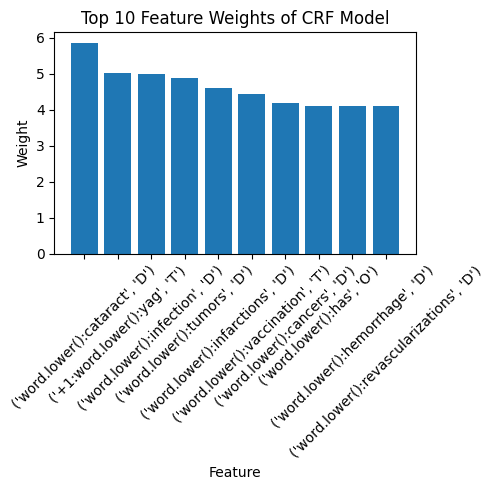

In [90]:
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF

# Assuming crf is your trained CRF model
# Example: crf = CRF(max_iterations=100, c1=1.0, c2=0.01, all_possible_transitions=False)
# crf.fit(X_train, y_train)

# Get the model's state features (weights)
state_features = crf.state_features_

# Extract and sort features based on their absolute weights across all labels
sorted_features = sorted(state_features.items(), key=lambda x: abs(x[1]), reverse=True)

# Extract top 30 features and their weights
top_features = sorted_features[:10]
top_feature_names = [f[0] for f in top_features]
top_weights = [f[1] for f in top_features]

# Plotting top weights
plt.figure(figsize=(5, 5))
plt.bar(range(len(top_weights)), top_weights, align='center')
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Top 10 Feature Weights of CRF Model')
plt.xticks(range(len(top_weights)), top_feature_names, rotation=45)
plt.tight_layout()
plt.show()
